In [2]:
import pandas as pd
import math
import csv

In [3]:
hh_cols = ['hhlivingsituation', 'hhnumdependentchildren', 'hhvehiclenumber', 'familyincomelevel', 'HmTTS2006']
hh_rename = ['Liv_Arr', 'Children', 'Cars', 'Income', 'Home_Zone']
df = pd.read_csv('SMTO_2019/SMTO_2019_Households.csv', low_memory=False)[hh_cols]
df = df.rename(columns = dict(zip(hh_cols, hh_rename)))
df.head()

,Liv_Arr,Children,Cars,Income,Home_Zone
0,Live with family/parents,0.0,0.0,NaN,3851.0
1,Live with family/parents,0.0,1.0,NaN,181.0
2,Live with family/parents,0.0,2.0,I don't know,1039.0
3,NaN,NaN,NaN,NaN,191.0
4,Live with family/parents,1.0,1.0,NaN,600.0


In [4]:
ps_cols = ['psinstitution', 'personstatusgrad ', 'personstatustime', 'pscollegeaffiliation', 'pscampusmain',
          'psworknumhoursperweek', 'psdrivinglicenseowner', 'psmainmodefalltypical', 'psage']
ps_rename = ['School', 'Uni_Level', 'Uni_Status', 'Col_Status', 'Campus', 'Work', 'Licence', 'Mode', 'Age']
df = df.join(pd.read_csv('SMTO_2019/SMTO_2019_Respondents.csv', low_memory=False)[ps_cols])
df = df.rename(columns = dict(zip(ps_cols, ps_rename)))
df.head()

,Liv_Arr,Children,Cars,Income,Home_Zone,School,Uni_Level,Uni_Status,Col_Status,Campus,Work,Licence,Mode,Age
0,Live with family/parents,0.0,0.0,NaN,3851.0,Centennial College,NaN,NaN,Full-Time,Progress Campus,I don't work,No,GO Bus,26.0
1,Live with family/parents,0.0,1.0,NaN,181.0,Centennial College,NaN,NaN,Part-Time,Morningside Campus,I don't work,No,Transit Bus,25.0
2,Live with family/parents,0.0,2.0,I don't know,1039.0,Centennial College,NaN,NaN,Full-Time,Progress Campus,I don't work,No,GO Bus,19.0
3,NaN,NaN,NaN,NaN,191.0,Centennial College,NaN,NaN,Full-Time,Progress Campus,I don't work,No,NaN,25.0
4,Live with family/parents,1.0,1.0,NaN,600.0,Centennial College,NaN,NaN,Full-Time,Progress Campus,I don't work,No,NaN,97.0


In [5]:
df['Campus'] = df.apply(lambda x: x.School if x.School in ('Ryerson University', 'OCAD University') else x.Campus, axis=1)
df['School_Type'] = df['School'].apply(lambda x: 'College' if 'College' in x else 'University')
df['Col_Status'].replace({'Full-Time': 'FT', 'Part-Time ':'PT', 'Continuing Education': 'Other'}, inplace=True)
df['Work'].replace({"I don't work": 'NW', 'I work 11-20 hours per week': 'PT', 'I work < 11 hours per week': 'PT', 'I work 21-30 hours per week': 'PT', 'I work 31-40 hours per week': 'FT', 'I work > 40 hours per week': 'FT'}, inplace=True)
df['Licence'] = df['Licence'].apply(lambda x: True if x=="Yes" else (False if x=="No" else None))
df['Family'] = df['Liv_Arr'].apply(lambda x: (x == 'Live with family/parents') if isinstance(x, str) else None)


In [6]:
def row_to_level(x):
    return x.Uni_Level if isinstance(x.Uni_Level, str) else ("College" if x.School_Type == 'College' else None)
def row_to_status(x):
    return x.Uni_Status if isinstance(x.Uni_Status, str) else (x.Col_Status if isinstance(x.Col_Status, str) else None)

df['Level'] = df.apply(row_to_level, axis=1)
df['Status'] = df.apply(row_to_status, axis=1)
df.drop(columns=['Uni_Level', 'Uni_Status', 'Col_Status'], inplace=True)

In [7]:
active = ['Walk', 'Bicycle', 'Bikeshare']
auto = ['Drive alone', 'Auto passenger (driver is a household member)', 'Drive with passenger(s) (household members only)',
        'Accessibility adapted vehicle as driver', 'Drive with passenger(s) (including non-household members)', 'Accessibility adapted vehicle as passenger',
       'Ride-hailing alone (UberX, Lyft etc.)', 'Auto passenger (driver is a non-household member)', 'Taxi', 'Ride-hailing with other passengers (Uberpool, Lyftpool etc.)']
transit = ['Transit Bus', 'Subway/RT', 'GO Train', 'GO Bus', 'Paratransit service (e.g., bus transport for disabled persons)', 'Streetcar']
def mode_to_aggr(mode):
    if mode in active:
        return 'Active'
    elif mode in auto:
        return 'Auto'
    elif mode in transit:
        return 'Transit'
    elif mode == 'I do not travel to the university (distance learners only)':
        return 'Do not travel'
    elif isinstance(mode, str):
        return 'Other'
    else:
        return None
    
df['Mode'] = df['Mode'].apply(mode_to_aggr)

In [8]:
df = df[(df['Status'] == 'FT') | (df['Status'] == 'PT')]
df = df[df['Campus'].notnull()]
df = df[df['Mode'] != 'Do not travel']
df = df[df['Home_Zone'].notnull()]

Drop Status=Other, Campus=Unknown?, Do not travel, missing HZ
Replace unknowns and np.nans
Reformat income

In [9]:
campus_info = pd.read_csv('School_Info_2019.csv').set_index('Campus')
zones, codes = list(campus_info['Zone']), list(campus_info['Code'])
df['Campus_Zone'] = df['Campus'].apply(lambda x: campus_info['Zone'].loc[x] if isinstance(x, str) else -1)
df['School'] = df['Campus'].apply(lambda x: campus_info['Code'].loc[x] if isinstance(x, str) else -1)
campus_info.head()

,Code,Zone,UG,Grad,Total,Tuition,Domestic_UG,Domestic_Grad,Admission
Campus,,,,,,,,,
Story Arts Centre,CST,282,NaN,NaN,"1,425",NaN,NaN,NaN,NaN
Ashtonbee Campus,CAS,526,NaN,NaN,"2,332",NaN,NaN,NaN,NaN
Progress Campus,CPR,493,NaN,NaN,"11,871",NaN,NaN,NaN,NaN
Morningside Campus,CMO,564,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Downsview Campus,CDV,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
df_path = pd.read_csv('../../LoS/Walk_Distances.csv')
origins = list(set(list(df_path['Origin'])))
dists = list(df_path['Data'])

In [84]:
def get_distance(o, d):
    if o in origins and d in origins:
        i = origins.index(o)
        j = origins.index(d)
        return dists[i*2392 + j] / 1000
    else:
        return -1    

In [85]:
for i in range(len(codes)):
    df['Dist.' + codes[i]] = df['Home_Zone'].apply(lambda x: get_distance(x, zones[i]))
df = df[df['Dist.CST'] != -1]

Load campus data from campus_info
Take correct enrollment and domestic values by level/status
Decide how to handle expansion factors

In [86]:
grouped = df.groupby('Level')['School'].value_counts()
school_counts = df['School'].value_counts()

def level_count(school, level):
    if "College" in school:
        return grouped['College'][school] / grouped.sum()
    if level != 'Total':
        return grouped[level][school] / grouped.sum()
    return school_counts[school]

In [21]:
def get_log_enrollment(level, school):
    return math.log1p(campus_info[level].loc[school]) # Level: UG, Grad, Total
    
exp_factors = {'Total': {}, 'UG': {}, 'Grad': {}}
for school in campus_info.index:
    code = campus_info['Code'][school]
    for level in ('Total', 'UG', 'Grad'):
        exp_factors[level][school] = campus_info[level][school] / campus_info[level].sum() / level_count(school, level)
        df[level + "." + code] = get_log_enrollment(level, school)
    df["Tuition." + code] = campus_info['Tuition'][school]
    df["Domestic." + code] = df['Level'].apply(lambda x: campus_info['Domestic_' + ('Grad' if (x == 'Grad') else 'UG')][school])  
    df["Adm_Ave." + code] = campus_info['Admission'][school]
    
    exp_factors[school] = campus_info[]

SyntaxError: invalid syntax (<ipython-input-21-ad774b608d35>, line 14)

In [87]:
campus_info.set_index(campus_info['Code'],inplace = True)

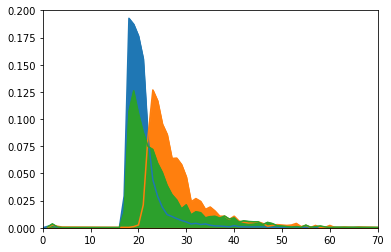

In [10]:
df[df['Level'] == 'UG']['Age'].value_counts(normalize = True).sort_index().plot.area(xlim = [0,70], ylim = [0,0.2])
df[df['Level'] == 'Grad']['Age'].value_counts(normalize = True).sort_index().plot.area(xlim = [0,70], ylim = [0,0.2])
df[df['Level'] == 'College']['Age'].value_counts(normalize = True).sort_index().plot.area(xlim = [0,70], ylim = [0,0.2])

In [21]:
xs = df['Age'].unique()
xs.sort()
UGs, Grads, Colleges = [], [], []
for age in xs:
    temp = df[df['Age'] == age]['Level'].value_counts(normalize=True)
    UGs.append(temp['UG'] if 'UG' in temp else 0)
    Grads.append(temp['Grad'] if 'Grad' in temp else 0)
    Colleges.append(temp['College'] if 'College' in temp else 0)

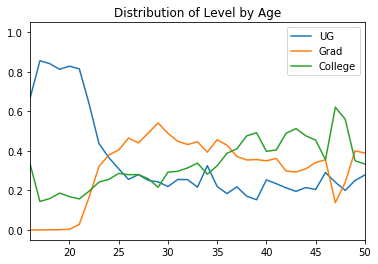

In [29]:
import matplotlib.pyplot as plt
plt.plot(xs, UGs)
plt.plot(xs, Grads)
plt.plot(xs, Colleges)
plt.xlim(16, 50)
plt.legend(labels=['UG', 'Grad', 'College'])
plt.title('Distribution of Level by Age')
plt.show()

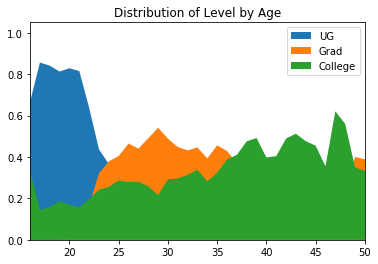

In [30]:
import matplotlib.pyplot as plt
plt.stackplot(xs, UGs)
plt.stackplot(xs, Grads)
plt.stackplot(xs, Colleges)
plt.xlim(16, 50)
plt.legend(labels=['UG', 'Grad', 'College'])
plt.title('Distribution of Level by Age')
plt.show()

In [33]:
xs = df['Age'].unique()
xs.sort()
UGs, Grads, Colleges = [], [], []
for age in xs:
    temp = df[df['Age'] == age]['Level'].value_counts(normalize=True)
    UG, Grad, College = temp['UG'] if 'UG' in temp else 0, temp['Grad'] if 'Grad' in temp else 0, temp['College'] if 'College' in temp else 0
    UGs.append(UG)
    Grads.append(UG + Grad)
    Colleges.append(UG + Grad + College)

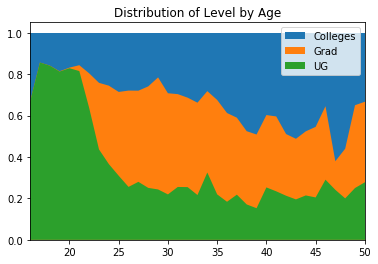

In [36]:
import matplotlib.pyplot as plt
plt.stackplot(xs, Colleges)
plt.stackplot(xs, Grads)
plt.stackplot(xs, UGs)
plt.xlim(16, 50)
plt.legend(labels=['Colleges', 'Grad', 'UG'])
plt.title('Distribution of Level by Age')
plt.show()

In [37]:
xs = df['Age'].unique()
xs.sort()
UGs, Grads, Colleges = [], [], []
for age in xs:
    temp = df[df['Age'] == age]['Level'].value_counts()
    UG, Grad, College = temp['UG'] if 'UG' in temp else 0, temp['Grad'] if 'Grad' in temp else 0, temp['College'] if 'College' in temp else 0
    UGs.append(UG)
    Grads.append(UG + Grad)
    Colleges.append(UG + Grad + College)

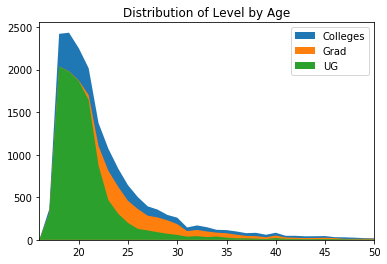

In [38]:
import matplotlib.pyplot as plt
plt.stackplot(xs, Colleges)
plt.stackplot(xs, Grads)
plt.stackplot(xs, UGs)
plt.xlim(16, 50)
plt.legend(labels=['Colleges', 'Grad', 'UG'])
plt.title('Distribution of Level by Age')
plt.show()

In [95]:
temp_enroll = df[df['Status'] == 'FT']['School'].value_counts()
temp_enroll

RY     3352
SG     3270
YK     1846
MCM    1399
DOS     837
SC      724
MI      702
OTN     490
CPR     486
MOF     417
SHT     395
OC      361
SHD     313
CMO     250
SHH     220
YG      139
DWH     125
OTD     124
CAS      87
CST      68
MOI      49
MCB      29
CDV      26
MOS      23
CPI      20
CEG       4
CDS       2
Name: School, dtype: int64

In [127]:
campus_info['Sample_Total'] = df['School'].value_counts()
campus_info['Sample_UG'] = df[df['Level'] == 'UG']['School'].value_counts()
campus_info['Sample_Grad'] = df[df['Level'] == 'Grad']['School'].value_counts()
campus_info['Sample_College'] = df[df['Level'] == 'College']['School'].value_counts()
campus_info['Sample_FT'] = df[df['Status'] == 'FT']['School'].value_counts()
campus_info['Sample_PT'] = df[df['Status'] == 'PT']['School'].value_counts()


campus_info[['Sample_Total', 'Sample_UG', 'Sample_Grad', 'Sample_College','Sample_PT', 'Sample_FT']] = campus_info[['Sample_Total', 'Sample_UG', 'Sample_Grad', 'Sample_College','Sample_PT', 'Sample_FT']].fillna(0)

In [151]:
math.log1p(2.718)

1.3131858892992523

In [152]:
for i in campus_info['Code'].tolist():
    df['Sample_Total.' + i] = math.log1p(campus_info['Sample_Total'][i])
for i in campus_info['Code'].tolist():
    df['Sample_UG.' + i] = math.log1p(campus_info['Sample_UG'][i])
for i in campus_info['Code'].tolist():
    df['Sample_Grad.' + i] = math.log1p(campus_info['Sample_Grad'][i])
for i in campus_info['Code'].tolist():
    df['Sample_College.' + i] = math.log1p(campus_info['Sample_College'][i])
for i in campus_info['Code'].tolist():
    df['Sample_FT.' + i] = math.log1p(campus_info['Sample_FT'][i])
for i in campus_info['Code'].tolist():
    df['Sample_PT.' + i] = math.log1p(campus_info['Sample_PT'][i])   

In [153]:
df.head()

,Liv_Arr,Children,Cars,Income,Home_Zone,School,Campus,Work,Licence,Mode,...,Sample_PT.SHD,Sample_PT.SHH,Sample_PT.SHT,Sample_PT.MI,Sample_PT.SC,Sample_PT.SG,Sample_PT.YK,Sample_PT.YG,Sample_PT.RY,Sample_PT.OC
0,Live with family/parents,0.0,0.0,NaN,3851.0,CPR,Progress Campus,NW,False,Transit,...,3.091042,2.397895,2.944439,3.218876,3.178054,5.298317,4.736198,1.386294,5.062595,3.555348
1,Live with family/parents,0.0,1.0,NaN,181.0,CMO,Morningside Campus,NW,False,Transit,...,3.091042,2.397895,2.944439,3.218876,3.178054,5.298317,4.736198,1.386294,5.062595,3.555348
2,Live with family/parents,0.0,2.0,I don't know,1039.0,CPR,Progress Campus,NW,False,Transit,...,3.091042,2.397895,2.944439,3.218876,3.178054,5.298317,4.736198,1.386294,5.062595,3.555348
3,NaN,NaN,NaN,NaN,191.0,CPR,Progress Campus,NW,False,None,...,3.091042,2.397895,2.944439,3.218876,3.178054,5.298317,4.736198,1.386294,5.062595,3.555348
4,Live with family/parents,1.0,1.0,NaN,600.0,CPR,Progress Campus,NW,False,None,...,3.091042,2.397895,2.944439,3.218876,3.178054,5.298317,4.736198,1.386294,5.062595,3.555348


In [154]:
df.to_csv('SMTO_2019/SMTO_2019_Complete_Input.csv', index = False)